In [90]:
import torch
import torchvision
import torchvision.transforms.v2 as v2
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import random_split
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
from torch.cuda.amp import autocast, GradScaler
from matplotlib import pyplot as plt
import torch.nn.functional as F


scaler = GradScaler()



C:\Users\abobantai\AppData\Local\Temp\ipykernel_20012\3584028125.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [78]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [79]:
transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
train_transform = v2.Compose([
    v2.RandomCrop(32, padding=4),
    v2.RandomHorizontalFlip(),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    v2.RandomRotation(10),
    v2.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    v2.RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    v2.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    v2.ToTensor(),
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



In [80]:
trainset = torchvision.datasets.CIFAR10(root='C:/Users/abobantai/Desktop/IT/CIFAR-10_PyTorch', download=True, train=True, transform=train_transform)
train_data, val_data = random_split(trainset, [0.8, 0.2])
testset = torchvision.datasets.CIFAR10(root='C:/Users/abobantai/Desktop/IT/CIFAR-10_PyTorch', download=True, train=False, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [81]:
train_data = torch.utils.data.DataLoader(train_data, batch_size=512, shuffle=True, num_workers=2, pin_memory=True)
val_data = torch.utils.data.DataLoader(val_data, batch_size=512, shuffle=True, num_workers=2, pin_memory=True)
test_data = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False)
val_data.dataset.transform = transform


In [82]:
# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, downsample=False):
#         super().__init__()
#         stride = 2 if downsample else 1
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU(inplace=True)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(out_channels)

        
#         self.shortcut = nn.Sequential()
#         if in_channels != out_channels or downsample:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(out_channels)
#             )

#     def forward(self, x):
#         y = self.conv1(x)
#         y = self.bn1(y)
#         y = self.conv2(y)
#         y = self.bn2(y)
#         y += self.shortcut(x) 
#         return self.relu(y)


In [ ]:


class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet110():
    return ResNet(BasicBlock, [18, 18, 18])


In [ ]:
# class MyModel(nn.Module):
#     def __init__(self, num_classes=10):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.relu = nn.ReLU(inplace=True)

#         self.layer1 = ResidualBlock(32, 64, downsample=True) 
#         self.layer2 = ResidualBlock(64, 128, downsample=True) 
#         self.layer3 = ResidualBlock(128, 256, downsample=True) 
#         self.layer4 = ResidualBlock(256, 512, downsample=True) 
#         self.layer11 = ResidualBlock(64, 64, downsample=True) 
#         self.layer22 = ResidualBlock(128, 128, downsample=True) 
#         self.layer33 = ResidualBlock(256, 256, downsample=True) 
#         self.layer44 = ResidualBlock(512, 512, downsample=True) 

#         self.avgpool = nn.AdaptiveAvgPool2d((1,1)) 

#         self.fc = nn.Sequential(nn.Linear(512, 256),
#                                 nn.ReLU(inplace=True),
#                                 nn.Dropout(0.5),
#                                 nn.Linear(256, 64),
#                                 nn.ReLU(inplace=True),
#                                 nn.Dropout(0.5),
#                                 nn.Linear(64, num_classes))

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.layer1(x)
#         x = self.layer11(x)
#         x = self.layer2(x)
#         x = self.layer22(x)
#         x = self.layer3(x)
#         x = self.layer33(x)
#         x = self.layer4(x)
#         x = self.layer44(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.fc(x)
#         return x

# model = MyModel().to(device)

model = ResNet110().to(device)

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias) 
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias) 

initialize_weights(model)



In [85]:
train_loss = []
val_loss = []
val_accuracy = []
train_accuracy = []
lr_list = []
test_loss = 0
test_accuracy = 0
best_loss = None
count = 0
epochs = 200
lr = 0.1

In [86]:

optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=lr, 
    momentum=0.9, 
    weight_decay=5e-4
)
loss_model = nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.1, 
    patience=5, 
    verbose=True
)


In [87]:
count = 0
for epoch in range(epochs):
    train_loop = tqdm(train_data, leave=False)
    model.train()
    true_answers = 0
    total = 0
    running_train_loss = []
    for x, target in train_loop:
        x = x.to(device)
        target = target.to(torch.int64).to(device)
        with autocast():  # Автоматическое использование FP16
            prediction = model(x)
            loss = loss_model(prediction, target)
        optimizer.zero_grad()
        scaler.scale(loss).backward()  # Масштабирование градиентов
        scaler.step(optimizer)
        scaler.update()
        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss)/len(running_train_loss)
        true_answers += (prediction.argmax(1) == target).sum().item()
        total += target.size(0)
        mean_train_acc = true_answers / total
        train_loop.set_description(f'Epoch: {epoch+1}/{epochs}, train_loss: {mean_train_loss:.4f}, train_accuracy: {mean_train_acc:.4f}')
    train_accuracy.append(mean_train_acc)
    train_loss.append(mean_train_loss)
    with torch.no_grad():
        model.eval()
        true_answers = 0
        total = 0
        running_val_loss = []
        for x, target in val_data:
            x = x.to(device)
            target = target.to(torch.int64).to(device)
            with autocast():  # Автоматическое использование FP16
                prediction = model(x)
                loss = loss_model(prediction, target)
            running_val_loss.append(loss.item())
            true_answers += (prediction.argmax(1) == target).sum().item()
            total += target.size(0)
            mean_val_loss = sum(running_val_loss)/len(running_val_loss)
            mean_val_acc = true_answers / total
        val_accuracy.append(mean_val_acc)
        val_loss.append(mean_val_loss)
    if best_loss is None:
        best_loss = mean_val_loss
    elif mean_val_loss < best_loss:
        best_loss = mean_val_loss
        checkpoint = {
            "state_model": model.state_dict(),
            "state_optimizer": optimizer.state_dict(),
            "state_scheduler": scheduler.state_dict(),
            "loss": {
                "train_loss": train_loss,
                "val_loss": val_loss,
                "best_loss": best_loss
            },
            "metric":{
                "train_accuracy": train_accuracy,
                "val_accuracy": val_accuracy
            },
            "lr": lr_list,
            "epoch": {
                "epochs": epochs,
                "save_epochs": epoch
            }
        }
        torch.save(checkpoint, f'checkpoints/model_state_dict.pt')
        print(f"checkpoint on epoch {epoch+1} with best val metrics: {mean_val_loss:.6f}")
        count = 0
    else:
        count += 1
    if count == 20:
        print('Early stopping on epoch:', epoch+1)
        break
    
    lr = optimizer.param_groups[0]['lr']
    lr_list.append(lr)
    scheduler.step(mean_val_loss)
    print(f'epoch: {epoch+1}/{epochs}, train_loss: {mean_train_loss:.4f}, train_accuracy: {mean_train_acc:.4f}, val_loss: {mean_val_loss:.4f}, val_accuracy: {mean_val_acc:.4f},without best_loss: {count}, lr: {lr}')
        

  0%|          | 0/79 [00:00<?, ?it/s]C:\Users\abobantai\AppData\Local\Temp\ipykernel_20012\158976237.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Автоматическое использование FP16
C:\Users\abobantai\AppData\Local\Temp\ipykernel_20012\158976237.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Автоматическое использование FP16


epoch: 1/200, train_loss: 3.1643, train_accuracy: 0.1037, val_loss: 2.3318, val_accuracy: 0.1020,without best_loss: 0, lr: 0.1


epoch: 2/200, train_loss: 2.3089, train_accuracy: 0.1052, val_loss: 2.3352, val_accuracy: 0.1106,without best_loss: 1, lr: 0.1


checkpoint on epoch 3 with best val metrics: 2.290191
epoch: 3/200, train_loss: 2.2974, train_accuracy: 0.1152, val_loss: 2.2902, val_accuracy: 0.1190,without best_loss: 0, lr: 0.1


epoch: 4/200, train_loss: 2.2740, train_accuracy: 0.1278, val_loss: 2.3220, val_accuracy: 0.1440,without best_loss: 1, lr: 0.1


checkpoint on epoch 5 with best val metrics: 2.140468
epoch: 5/200, train_loss: 2.1940, train_accuracy: 0.1700, val_loss: 2.1405, val_accuracy: 0.1896,without best_loss: 0, lr: 0.1


epoch: 6/200, train_loss: 2.1208, train_accuracy: 0.2009, val_loss: 2.1537, val_accuracy: 0.1885,without best_loss: 1, lr: 0.1


epoch: 7/200, train_loss: 2.0867, train_accuracy: 0.2207, val_loss: 2.1421, val_accuracy: 0.1971,without best_loss: 2, lr: 0.1


epoch: 8/200, train_loss: 2.0501, train_accuracy: 0.2443, val_loss: 2.1622, val_accuracy: 0.2082,without best_loss: 3, lr: 0.1


checkpoint on epoch 9 with best val metrics: 1.993282
epoch: 9/200, train_loss: 1.9986, train_accuracy: 0.2814, val_loss: 1.9933, val_accuracy: 0.2779,without best_loss: 0, lr: 0.1


checkpoint on epoch 10 with best val metrics: 1.940977
epoch: 10/200, train_loss: 1.9437, train_accuracy: 0.3138, val_loss: 1.9410, val_accuracy: 0.3175,without best_loss: 0, lr: 0.1


epoch: 11/200, train_loss: 1.8959, train_accuracy: 0.3380, val_loss: 1.9633, val_accuracy: 0.3215,without best_loss: 1, lr: 0.1


epoch: 12/200, train_loss: 1.8583, train_accuracy: 0.3598, val_loss: 1.9649, val_accuracy: 0.3327,without best_loss: 2, lr: 0.1


Epoch: 13/200, train_loss: 1.8388, train_accuracy: 0.3735:  52%|█████▏    | 41/79 [00:18<00:11,  3.18it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002005D997790>
Traceback (most recent call last):
  File "C:\Users\abobantai\AppData\Roaming\Python\Python39\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "C:\Users\abobantai\AppData\Roaming\Python\Python39\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


checkpoint on epoch 13 with best val metrics: 1.877076
epoch: 13/200, train_loss: 1.8174, train_accuracy: 0.3838, val_loss: 1.8771, val_accuracy: 0.3636,without best_loss: 0, lr: 0.1


checkpoint on epoch 14 with best val metrics: 1.790237
epoch: 14/200, train_loss: 1.7759, train_accuracy: 0.4041, val_loss: 1.7902, val_accuracy: 0.3945,without best_loss: 0, lr: 0.1


checkpoint on epoch 15 with best val metrics: 1.777947
epoch: 15/200, train_loss: 1.7272, train_accuracy: 0.4225, val_loss: 1.7779, val_accuracy: 0.4028,without best_loss: 0, lr: 0.1


checkpoint on epoch 16 with best val metrics: 1.730179
epoch: 16/200, train_loss: 1.6906, train_accuracy: 0.4447, val_loss: 1.7302, val_accuracy: 0.4287,without best_loss: 0, lr: 0.1


checkpoint on epoch 17 with best val metrics: 1.692522
epoch: 17/200, train_loss: 1.6316, train_accuracy: 0.4763, val_loss: 1.6925, val_accuracy: 0.4495,without best_loss: 0, lr: 0.1


epoch: 18/200, train_loss: 1.5882, train_accuracy: 0.4979, val_loss: 1.8961, val_accuracy: 0.3947,without best_loss: 1, lr: 0.1


checkpoint on epoch 19 with best val metrics: 1.595028
epoch: 19/200, train_loss: 1.5394, train_accuracy: 0.5197, val_loss: 1.5950, val_accuracy: 0.4938,without best_loss: 0, lr: 0.1


checkpoint on epoch 20 with best val metrics: 1.519274
epoch: 20/200, train_loss: 1.5027, train_accuracy: 0.5415, val_loss: 1.5193, val_accuracy: 0.5303,without best_loss: 0, lr: 0.1


epoch: 21/200, train_loss: 1.4599, train_accuracy: 0.5624, val_loss: 1.6150, val_accuracy: 0.5053,without best_loss: 1, lr: 0.1


epoch: 22/200, train_loss: 1.4057, train_accuracy: 0.5873, val_loss: 1.6920, val_accuracy: 0.4656,without best_loss: 2, lr: 0.1


checkpoint on epoch 23 with best val metrics: 1.477538
epoch: 23/200, train_loss: 1.3890, train_accuracy: 0.5989, val_loss: 1.4775, val_accuracy: 0.5633,without best_loss: 0, lr: 0.1


epoch: 24/200, train_loss: 1.3574, train_accuracy: 0.6143, val_loss: 1.8289, val_accuracy: 0.4507,without best_loss: 1, lr: 0.1


checkpoint on epoch 25 with best val metrics: 1.375268
epoch: 25/200, train_loss: 1.3504, train_accuracy: 0.6164, val_loss: 1.3753, val_accuracy: 0.6008,without best_loss: 0, lr: 0.1


epoch: 26/200, train_loss: 1.3011, train_accuracy: 0.6440, val_loss: 1.4887, val_accuracy: 0.5562,without best_loss: 1, lr: 0.1


checkpoint on epoch 27 with best val metrics: 1.373101
epoch: 27/200, train_loss: 1.3105, train_accuracy: 0.6352, val_loss: 1.3731, val_accuracy: 0.6058,without best_loss: 0, lr: 0.1


checkpoint on epoch 28 with best val metrics: 1.362952
epoch: 28/200, train_loss: 1.2588, train_accuracy: 0.6609, val_loss: 1.3630, val_accuracy: 0.6216,without best_loss: 0, lr: 0.1


epoch: 29/200, train_loss: 1.2248, train_accuracy: 0.6746, val_loss: 1.4628, val_accuracy: 0.5711,without best_loss: 1, lr: 0.1


checkpoint on epoch 30 with best val metrics: 1.268749
epoch: 30/200, train_loss: 1.2090, train_accuracy: 0.6843, val_loss: 1.2687, val_accuracy: 0.6603,without best_loss: 0, lr: 0.1


epoch: 31/200, train_loss: 1.1877, train_accuracy: 0.6927, val_loss: 1.2843, val_accuracy: 0.6497,without best_loss: 1, lr: 0.1


epoch: 32/200, train_loss: 1.1750, train_accuracy: 0.6996, val_loss: 1.4700, val_accuracy: 0.5923,without best_loss: 2, lr: 0.1


epoch: 33/200, train_loss: 1.1650, train_accuracy: 0.7061, val_loss: 1.4091, val_accuracy: 0.6086,without best_loss: 3, lr: 0.1


epoch: 34/200, train_loss: 1.1571, train_accuracy: 0.7070, val_loss: 1.3298, val_accuracy: 0.6384,without best_loss: 4, lr: 0.1


epoch: 35/200, train_loss: 1.1288, train_accuracy: 0.7228, val_loss: 1.3412, val_accuracy: 0.6282,without best_loss: 5, lr: 0.1


epoch: 36/200, train_loss: 1.1360, train_accuracy: 0.7184, val_loss: 1.2981, val_accuracy: 0.6466,without best_loss: 6, lr: 0.1


checkpoint on epoch 37 with best val metrics: 1.044238
epoch: 37/200, train_loss: 1.0421, train_accuracy: 0.7585, val_loss: 1.0442, val_accuracy: 0.7563,without best_loss: 0, lr: 0.010000000000000002


checkpoint on epoch 38 with best val metrics: 1.030848
epoch: 38/200, train_loss: 1.0005, train_accuracy: 0.7787, val_loss: 1.0308, val_accuracy: 0.7632,without best_loss: 0, lr: 0.010000000000000002


epoch: 39/200, train_loss: 0.9829, train_accuracy: 0.7874, val_loss: 1.0375, val_accuracy: 0.7622,without best_loss: 1, lr: 0.010000000000000002


checkpoint on epoch 40 with best val metrics: 1.021075
epoch: 40/200, train_loss: 0.9758, train_accuracy: 0.7899, val_loss: 1.0211, val_accuracy: 0.7673,without best_loss: 0, lr: 0.010000000000000002


epoch: 41/200, train_loss: 0.9703, train_accuracy: 0.7903, val_loss: 1.0269, val_accuracy: 0.7652,without best_loss: 1, lr: 0.010000000000000002


checkpoint on epoch 42 with best val metrics: 1.005344
epoch: 42/200, train_loss: 0.9645, train_accuracy: 0.7950, val_loss: 1.0053, val_accuracy: 0.7759,without best_loss: 0, lr: 0.010000000000000002


checkpoint on epoch 43 with best val metrics: 1.001084
epoch: 43/200, train_loss: 0.9614, train_accuracy: 0.7947, val_loss: 1.0011, val_accuracy: 0.7813,without best_loss: 0, lr: 0.010000000000000002


checkpoint on epoch 44 with best val metrics: 0.993369
epoch: 44/200, train_loss: 0.9537, train_accuracy: 0.7987, val_loss: 0.9934, val_accuracy: 0.7815,without best_loss: 0, lr: 0.010000000000000002


epoch: 45/200, train_loss: 0.9471, train_accuracy: 0.8004, val_loss: 1.0055, val_accuracy: 0.7772,without best_loss: 1, lr: 0.010000000000000002


epoch: 46/200, train_loss: 0.9470, train_accuracy: 0.8035, val_loss: 1.0010, val_accuracy: 0.7758,without best_loss: 2, lr: 0.010000000000000002


epoch: 47/200, train_loss: 0.9411, train_accuracy: 0.8047, val_loss: 0.9970, val_accuracy: 0.7803,without best_loss: 3, lr: 0.010000000000000002


epoch: 48/200, train_loss: 0.9337, train_accuracy: 0.8092, val_loss: 0.9982, val_accuracy: 0.7812,without best_loss: 4, lr: 0.010000000000000002


checkpoint on epoch 49 with best val metrics: 0.989984
epoch: 49/200, train_loss: 0.9315, train_accuracy: 0.8098, val_loss: 0.9900, val_accuracy: 0.7798,without best_loss: 0, lr: 0.010000000000000002


epoch: 50/200, train_loss: 0.9289, train_accuracy: 0.8106, val_loss: 0.9908, val_accuracy: 0.7823,without best_loss: 1, lr: 0.010000000000000002


epoch: 51/200, train_loss: 0.9251, train_accuracy: 0.8126, val_loss: 0.9912, val_accuracy: 0.7812,without best_loss: 2, lr: 0.010000000000000002


checkpoint on epoch 52 with best val metrics: 0.982657
epoch: 52/200, train_loss: 0.9219, train_accuracy: 0.8157, val_loss: 0.9827, val_accuracy: 0.7858,without best_loss: 0, lr: 0.010000000000000002


checkpoint on epoch 53 with best val metrics: 0.977921
epoch: 53/200, train_loss: 0.9145, train_accuracy: 0.8184, val_loss: 0.9779, val_accuracy: 0.7910,without best_loss: 0, lr: 0.010000000000000002


checkpoint on epoch 54 with best val metrics: 0.970372
epoch: 54/200, train_loss: 0.9150, train_accuracy: 0.8152, val_loss: 0.9704, val_accuracy: 0.7907,without best_loss: 0, lr: 0.010000000000000002


epoch: 55/200, train_loss: 0.9107, train_accuracy: 0.8167, val_loss: 1.0046, val_accuracy: 0.7761,without best_loss: 1, lr: 0.010000000000000002


epoch: 56/200, train_loss: 0.9112, train_accuracy: 0.8201, val_loss: 0.9805, val_accuracy: 0.7856,without best_loss: 2, lr: 0.010000000000000002


epoch: 57/200, train_loss: 0.9072, train_accuracy: 0.8177, val_loss: 0.9825, val_accuracy: 0.7851,without best_loss: 3, lr: 0.010000000000000002


epoch: 58/200, train_loss: 0.9055, train_accuracy: 0.8209, val_loss: 0.9946, val_accuracy: 0.7793,without best_loss: 4, lr: 0.010000000000000002


epoch: 59/200, train_loss: 0.9016, train_accuracy: 0.8225, val_loss: 0.9784, val_accuracy: 0.7900,without best_loss: 5, lr: 0.010000000000000002


epoch: 60/200, train_loss: 0.8993, train_accuracy: 0.8238, val_loss: 1.0047, val_accuracy: 0.7814,without best_loss: 6, lr: 0.010000000000000002


checkpoint on epoch 61 with best val metrics: 0.945739
epoch: 61/200, train_loss: 0.8857, train_accuracy: 0.8307, val_loss: 0.9457, val_accuracy: 0.8055,without best_loss: 0, lr: 0.0010000000000000002


checkpoint on epoch 62 with best val metrics: 0.945732
epoch: 62/200, train_loss: 0.8709, train_accuracy: 0.8376, val_loss: 0.9457, val_accuracy: 0.8011,without best_loss: 0, lr: 0.0010000000000000002


checkpoint on epoch 63 with best val metrics: 0.937254
epoch: 63/200, train_loss: 0.8721, train_accuracy: 0.8361, val_loss: 0.9373, val_accuracy: 0.8066,without best_loss: 0, lr: 0.0010000000000000002


epoch: 64/200, train_loss: 0.8681, train_accuracy: 0.8368, val_loss: 0.9434, val_accuracy: 0.8013,without best_loss: 1, lr: 0.0010000000000000002


epoch: 65/200, train_loss: 0.8653, train_accuracy: 0.8419, val_loss: 0.9405, val_accuracy: 0.8062,without best_loss: 2, lr: 0.0010000000000000002


epoch: 66/200, train_loss: 0.8625, train_accuracy: 0.8394, val_loss: 0.9385, val_accuracy: 0.8040,without best_loss: 3, lr: 0.0010000000000000002


epoch: 67/200, train_loss: 0.8597, train_accuracy: 0.8419, val_loss: 0.9375, val_accuracy: 0.8067,without best_loss: 4, lr: 0.0010000000000000002


checkpoint on epoch 68 with best val metrics: 0.928244
epoch: 68/200, train_loss: 0.8657, train_accuracy: 0.8401, val_loss: 0.9282, val_accuracy: 0.8088,without best_loss: 0, lr: 0.0010000000000000002


epoch: 69/200, train_loss: 0.8558, train_accuracy: 0.8437, val_loss: 0.9289, val_accuracy: 0.8089,without best_loss: 1, lr: 0.0010000000000000002


epoch: 70/200, train_loss: 0.8590, train_accuracy: 0.8419, val_loss: 0.9319, val_accuracy: 0.8054,without best_loss: 2, lr: 0.0010000000000000002


epoch: 71/200, train_loss: 0.8602, train_accuracy: 0.8415, val_loss: 0.9357, val_accuracy: 0.8040,without best_loss: 3, lr: 0.0010000000000000002


epoch: 72/200, train_loss: 0.8577, train_accuracy: 0.8433, val_loss: 0.9336, val_accuracy: 0.8056,without best_loss: 4, lr: 0.0010000000000000002


epoch: 73/200, train_loss: 0.8625, train_accuracy: 0.8390, val_loss: 0.9291, val_accuracy: 0.8097,without best_loss: 5, lr: 0.0010000000000000002


epoch: 74/200, train_loss: 0.8573, train_accuracy: 0.8429, val_loss: 0.9412, val_accuracy: 0.8042,without best_loss: 6, lr: 0.0010000000000000002


checkpoint on epoch 75 with best val metrics: 0.926363
epoch: 75/200, train_loss: 0.8532, train_accuracy: 0.8450, val_loss: 0.9264, val_accuracy: 0.8077,without best_loss: 0, lr: 0.00010000000000000003


epoch: 76/200, train_loss: 0.8553, train_accuracy: 0.8428, val_loss: 0.9316, val_accuracy: 0.8078,without best_loss: 1, lr: 0.00010000000000000003


epoch: 77/200, train_loss: 0.8518, train_accuracy: 0.8473, val_loss: 0.9323, val_accuracy: 0.8098,without best_loss: 2, lr: 0.00010000000000000003


epoch: 78/200, train_loss: 0.8538, train_accuracy: 0.8447, val_loss: 0.9355, val_accuracy: 0.8056,without best_loss: 3, lr: 0.00010000000000000003


epoch: 79/200, train_loss: 0.8538, train_accuracy: 0.8424, val_loss: 0.9311, val_accuracy: 0.8099,without best_loss: 4, lr: 0.00010000000000000003


epoch: 80/200, train_loss: 0.8544, train_accuracy: 0.8424, val_loss: 0.9291, val_accuracy: 0.8105,without best_loss: 5, lr: 0.00010000000000000003


epoch: 81/200, train_loss: 0.8543, train_accuracy: 0.8440, val_loss: 0.9270, val_accuracy: 0.8087,without best_loss: 6, lr: 0.00010000000000000003


epoch: 82/200, train_loss: 0.8537, train_accuracy: 0.8421, val_loss: 0.9318, val_accuracy: 0.8073,without best_loss: 7, lr: 1.0000000000000004e-05


epoch: 83/200, train_loss: 0.8571, train_accuracy: 0.8439, val_loss: 0.9315, val_accuracy: 0.8076,without best_loss: 8, lr: 1.0000000000000004e-05


epoch: 84/200, train_loss: 0.8525, train_accuracy: 0.8469, val_loss: 0.9300, val_accuracy: 0.8102,without best_loss: 9, lr: 1.0000000000000004e-05


epoch: 85/200, train_loss: 0.8526, train_accuracy: 0.8440, val_loss: 0.9304, val_accuracy: 0.8075,without best_loss: 10, lr: 1.0000000000000004e-05


epoch: 86/200, train_loss: 0.8541, train_accuracy: 0.8458, val_loss: 0.9310, val_accuracy: 0.8094,without best_loss: 11, lr: 1.0000000000000004e-05


epoch: 87/200, train_loss: 0.8509, train_accuracy: 0.8450, val_loss: 0.9301, val_accuracy: 0.8075,without best_loss: 12, lr: 1.0000000000000004e-05


epoch: 88/200, train_loss: 0.8488, train_accuracy: 0.8465, val_loss: 0.9382, val_accuracy: 0.8053,without best_loss: 13, lr: 1.0000000000000004e-06


checkpoint on epoch 89 with best val metrics: 0.926150
epoch: 89/200, train_loss: 0.8553, train_accuracy: 0.8437, val_loss: 0.9262, val_accuracy: 0.8127,without best_loss: 0, lr: 1.0000000000000004e-06


epoch: 90/200, train_loss: 0.8537, train_accuracy: 0.8427, val_loss: 0.9267, val_accuracy: 0.8111,without best_loss: 1, lr: 1.0000000000000004e-06


epoch: 91/200, train_loss: 0.8528, train_accuracy: 0.8435, val_loss: 0.9294, val_accuracy: 0.8100,without best_loss: 2, lr: 1.0000000000000004e-06


epoch: 92/200, train_loss: 0.8530, train_accuracy: 0.8436, val_loss: 0.9305, val_accuracy: 0.8094,without best_loss: 3, lr: 1.0000000000000004e-06


epoch: 93/200, train_loss: 0.8531, train_accuracy: 0.8448, val_loss: 0.9324, val_accuracy: 0.8129,without best_loss: 4, lr: 1.0000000000000004e-06


epoch: 94/200, train_loss: 0.8517, train_accuracy: 0.8450, val_loss: 0.9373, val_accuracy: 0.8065,without best_loss: 5, lr: 1.0000000000000004e-06


epoch: 95/200, train_loss: 0.8530, train_accuracy: 0.8448, val_loss: 0.9334, val_accuracy: 0.8077,without best_loss: 6, lr: 1.0000000000000004e-06


epoch: 96/200, train_loss: 0.8534, train_accuracy: 0.8444, val_loss: 0.9370, val_accuracy: 0.8049,without best_loss: 7, lr: 1.0000000000000005e-07


epoch: 97/200, train_loss: 0.8528, train_accuracy: 0.8455, val_loss: 0.9287, val_accuracy: 0.8058,without best_loss: 8, lr: 1.0000000000000005e-07


epoch: 98/200, train_loss: 0.8526, train_accuracy: 0.8447, val_loss: 0.9348, val_accuracy: 0.8077,without best_loss: 9, lr: 1.0000000000000005e-07


epoch: 99/200, train_loss: 0.8585, train_accuracy: 0.8427, val_loss: 0.9375, val_accuracy: 0.8049,without best_loss: 10, lr: 1.0000000000000005e-07


epoch: 100/200, train_loss: 0.8558, train_accuracy: 0.8425, val_loss: 0.9276, val_accuracy: 0.8122,without best_loss: 11, lr: 1.0000000000000005e-07


epoch: 101/200, train_loss: 0.8465, train_accuracy: 0.8489, val_loss: 0.9318, val_accuracy: 0.8099,without best_loss: 12, lr: 1.0000000000000005e-07


epoch: 102/200, train_loss: 0.8515, train_accuracy: 0.8444, val_loss: 0.9389, val_accuracy: 0.8056,without best_loss: 13, lr: 1.0000000000000005e-08


epoch: 103/200, train_loss: 0.8545, train_accuracy: 0.8450, val_loss: 0.9364, val_accuracy: 0.8078,without best_loss: 14, lr: 1.0000000000000005e-08


epoch: 104/200, train_loss: 0.8557, train_accuracy: 0.8440, val_loss: 0.9292, val_accuracy: 0.8090,without best_loss: 15, lr: 1.0000000000000005e-08


epoch: 105/200, train_loss: 0.8556, train_accuracy: 0.8432, val_loss: 0.9282, val_accuracy: 0.8085,without best_loss: 16, lr: 1.0000000000000005e-08


epoch: 106/200, train_loss: 0.8543, train_accuracy: 0.8441, val_loss: 0.9304, val_accuracy: 0.8090,without best_loss: 17, lr: 1.0000000000000005e-08


epoch: 107/200, train_loss: 0.8514, train_accuracy: 0.8449, val_loss: 0.9357, val_accuracy: 0.8069,without best_loss: 18, lr: 1.0000000000000005e-08


epoch: 108/200, train_loss: 0.8528, train_accuracy: 0.8447, val_loss: 0.9284, val_accuracy: 0.8106,without best_loss: 19, lr: 1.0000000000000005e-08


Early stopping on epoch: 109


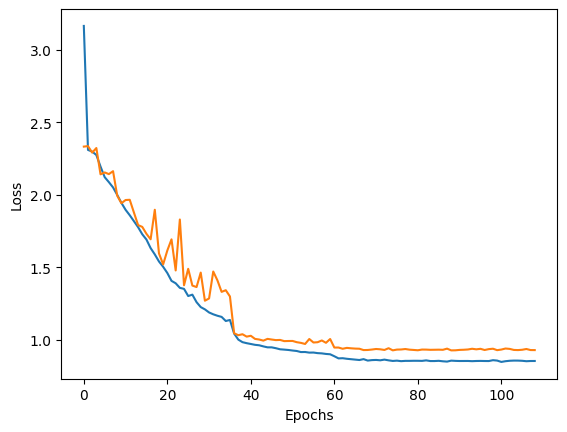

In [91]:
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')  
plt.show()

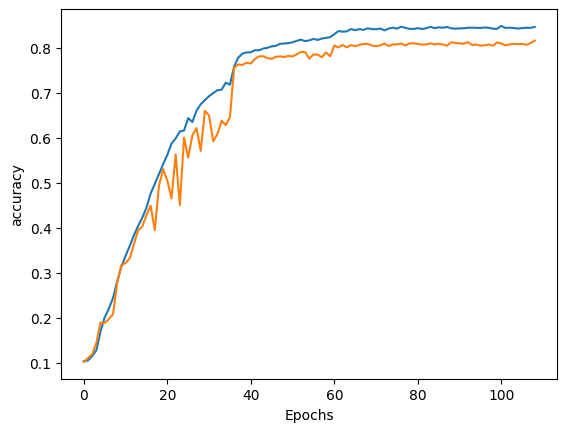

In [92]:
plt.plot(train_accuracy, label='train_acc')
plt.plot(val_accuracy, label='val_acc')
plt.xlabel('Epochs')
plt.ylabel('accuracy')  
plt.show()

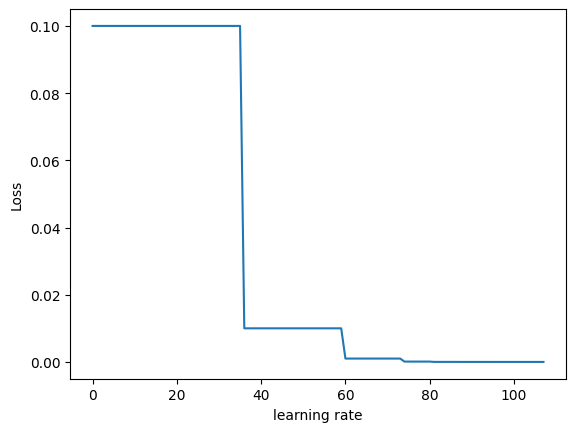

In [93]:

plt.plot(lr_list, label='lr')
plt.xlabel('learning rate')
plt.ylabel('Loss')  
plt.show()

In [88]:
with torch.no_grad():
        model.eval()
        true_answers = 0
        total = 0
        running_test_loss = []
        for x, target in test_data:
            x = x.to(device)
            target = target.to(torch.int64).to(device)
            prediction = model(x)
            loss = loss_model(prediction, target)
            running_test_loss.append(loss.item())
            true_answers += (prediction.argmax(1) == target).sum().item()
            total += target.size(0)
            mean_test_loss = sum(running_test_loss)/len(running_test_loss)
            mean_test_acc = true_answers / total
        test_accuracy=mean_test_acc
        test_loss=mean_test_loss
        print(test_accuracy)
        print(test_loss)

0.8637
0.8126671642065049
